# 803 Generative Adversarial Networks MNIST

A partir del código de Jordi Torres:

https://github.com/jorditorresBCN/python-deep-learning/blob/master/14_Generative_Adversarial_Networks.ipynb

Parte de su libro:

[**Python Deep Learning** Introducción práctica con Keras y TensorFlow 2. Jordi Torres. Editorial Marcombo ISBN: 9788426728289 ](https://www.marcombo.com/python-deep-learning-9788426728289/)

Complementado con ideas a partir de

https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb#scrollTo=MOZH6adEMcQQ


In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2023-12-12 21:10:14.923222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 21:10:14.923294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 21:10:14.923354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 21:10:14.933447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 21:10:17.155559: W tensorflow/compiler/

2.14.0


In [2]:
!nvidia-smi

/bin/bash: línea 1: nvidia-smi: orden no encontrada


In [3]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-12-12 21:10:20.854340: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


## Modelos

### Generador

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model



In [6]:
generator = make_generator_model()
generator.summary ()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       819328    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 14, 14, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 64)        2

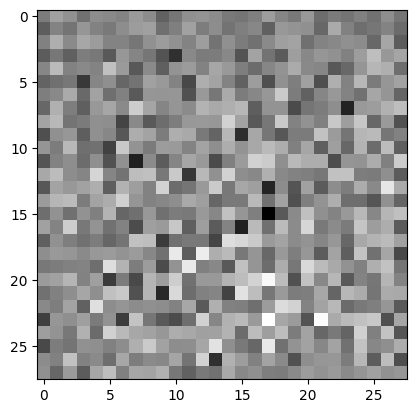

In [7]:
noise_dim = 100
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminador

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU, Conv2D

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model



In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

discriminator.summary ()

tf.Tensor([[0.49973014]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         204928    

## Funciones de *Loss* y optimizadores


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizadores

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Entrenamiento

###Training step



In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Training loop

In [15]:
import time

grid_size_x= 10
grid_size_y= 10
seed = tf.random.normal([grid_size_x*grid_size_y , noise_dim])

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    generate_images(generator,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_images(generator, seed)

### Visualización de las imagenes (en realidad solo las que genera el Generador para ver que va aprendiendo)



In [16]:
def generate_images(model, test_input):

    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(grid_size_x,grid_size_y))
    for i in range(predictions.shape[0]):
        plt.subplot(grid_size_x, grid_size_y, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

### Entrenar el model

2023-12-12 21:10:22.208440: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
/home/pedro/Escritorio/UTAD_22_23/INAR_22_23/grupo_b/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


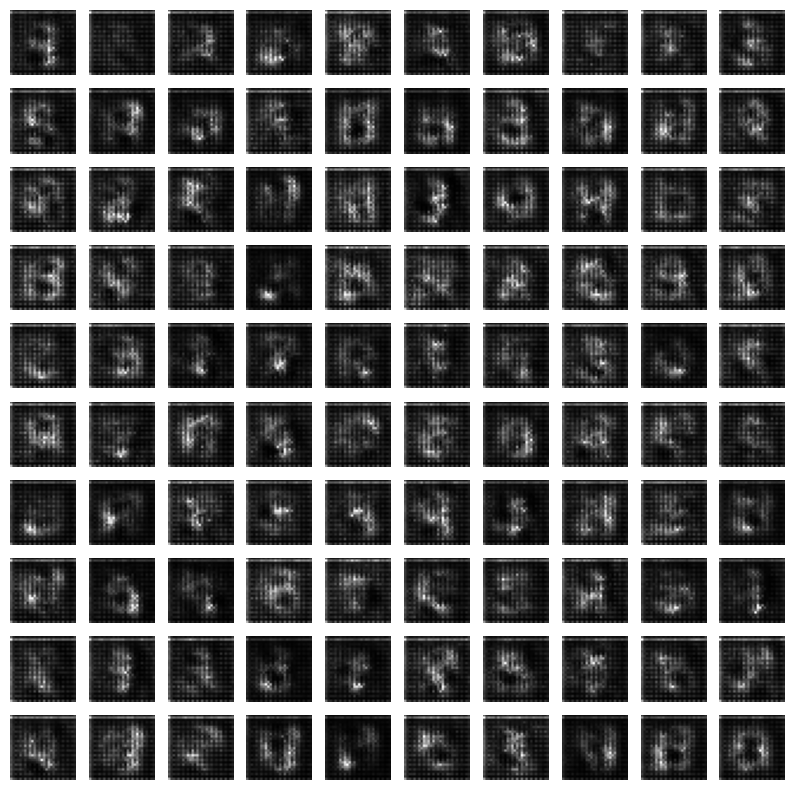

Time for epoch 100 is 717.8303236961365 sec


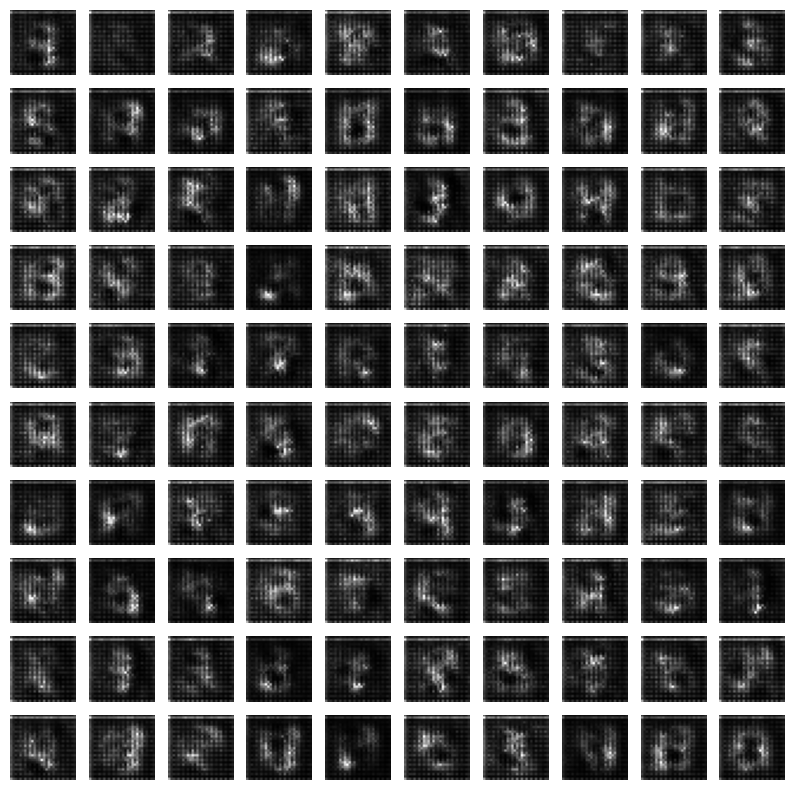

In [17]:
## %%time
EPOCHS = 100
train(train_dataset, EPOCHS)